<a href="https://colab.research.google.com/github/fabioalvero/COIL/blob/main/GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Correct setup (NO pandas upgrade)
!pip install yfinance --quiet

import pandas as pd
import yfinance as yf

print("Setup complete: Using pandas version", pd.__version__)

Setup complete: Using pandas version 2.2.2


In [ ]:
# MAIN - Download, merge, clean and save (GBPUSD version)
import pandas as pd
import yfinance as yf

start_date = "2021-01-01"
end_date   = "2024-06-30"

# 1) GBPUSD (target)
gbpusd = yf.download("GBPUSD=X", start=start_date, end=end_date)
gbpusd = gbpusd[["Close"]].rename(columns={"Close": "GBPUSD"})
gbpusd.index.name = "Date"

# 2) US Dollar Index (DXY)
dxy = yf.download("DX-Y.NYB", start=start_date, end=end_date)
dxy = dxy[["Close"]].rename(columns={"Close": "DXY"})

# 3) Gold prices
gold = yf.download("GC=F", start=start_date, end=end_date)
gold = gold[["Close"]].rename(columns={"Close": "Gold_Price"})

# 4) S&P 500
sp500 = yf.download("^GSPC", start=start_date, end=end_date)
sp500 = sp500[["Close"]].rename(columns={"Close": "SP500"})

# 5) Merge - align by date
df = gbpusd.join([dxy, gold, sp500], how="outer")

# 6) Handle missing values
df = df.ffill().bfill()

# 7) Save
df.to_csv("final_dataset.csv")
df.head()


/tmp/ipython-input-4017326153.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gbpusd = yf.download("GBPUSD=X", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4017326153.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dxy = yf.download("DX-Y.NYB", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4017326153.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download("GC=F", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4017326153.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,GBPUSD,DXY,Gold_Price,SP500
Ticker,GBPUSD=X,DX-Y.NYB,GC=F,^GSPC
Date,,,,
2021-01-01,1.367301,89.879997,1944.699951,3700.649902
2021-01-04,1.368420,89.879997,1944.699951,3700.649902
2021-01-05,1.357160,89.440002,1952.699951,3726.860107
2021-01-06,1.362955,89.529999,1906.900024,3748.139893
2021-01-07,1.362528,89.830002,1912.300049,3803.790039


In [ ]:
from google.colab import files
files.download("final_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

df = pd.read_csv("final_dataset.csv")   # replace with your file name
df.head()


,Price,GBPUSD,DXY,Gold_Price,SP500
0,Ticker,GBPUSD=X,DX-Y.NYB,GC=F,^GSPC
1,Date,NaN,NaN,NaN,NaN
2,2021-01-01,1.3673007488250732,89.87999725341797,1944.699951171875,3700.64990234375
3,2021-01-04,1.3684196472167969,89.87999725341797,1944.699951171875,3700.64990234375
4,2021-01-05,1.3571596145629883,89.44000244140625,1952.699951171875,3726.860107421875


In [ ]:
df.columns


Index(['Price', 'GBPUSD', 'DXY', 'Gold_Price', 'SP500'], dtype='object')

In [ ]:
import pandas as pd
vars_in_memory = [var for var in globals() if isinstance(globals()[var], pd.DataFrame)]
vars_in_memory


['__', '___', 'gbpusd', 'dxy', 'gold', 'sp500', 'df', '_2', '_4']

In [ ]:
df.columns


Index(['Price', 'GBPUSD', 'DXY', 'Gold_Price', 'SP500'], dtype='object')

In [ ]:
import pandas as pd
import numpy as np

# Convert relevant columns to numeric, coercing errors to NaN
cols_to_convert = ['GBPUSD', 'Gold_Price', 'SP500', 'DXY']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values that resulted from the conversion (removes metadata rows)
df = df.dropna().reset_index(drop=True)

# 1. Compute daily return for GBPUSD
df['fx_return'] = df['GBPUSD'].pct_change()

# 2. Compute returns for other market features
df['gold_ret'] = df['Gold_Price'].pct_change()
df['sp500_ret'] = df['SP500'].pct_change()
df['dxy_ret'] = df['DXY'].pct_change()

# 3. Drop rows with NaN (from pct_change, including the first row after cleaning)
df = df.dropna().reset_index(drop=True)

# 4. Define features and target
feature_cols = ['gold_ret', 'sp500_ret', 'dxy_ret']   # explanatory variables
X = df[feature_cols]
y = df['fx_return']

# Quick check
print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()

X shape: (910, 3)
y shape: (910,)


,gold_ret,sp500_ret,dxy_ret
0,0.000000,0.000000,0.000000
1,0.004114,0.007083,-0.004895
2,-0.023455,0.005710,0.001006
3,0.002832,0.014847,0.003351
4,-0.040893,0.005492,0.003006


In [ ]:
# Convert relevant columns to numeric
cols_to_convert = ['GBPUSD', 'Gold_Price', 'SP500', 'DXY']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # invalid parsing becomes NaN

# Check for any NaN values in these columns
print(df[cols_to_convert].isna().sum())


GBPUSD        0
Gold_Price    0
SP500         0
DXY           0
dtype: int64


In [ ]:
# Compute daily returns
df['fx_return'] = df['GBPUSD'].pct_change()
df['gold_ret'] = df['Gold_Price'].pct_change()
df['sp500_ret'] = df['SP500'].pct_change()
df['dxy_ret'] = df['DXY'].pct_change()

# Drop rows with NaN
df = df.dropna().reset_index(drop=True)

# Features and target
feature_cols = ['gold_ret', 'sp500_ret', 'dxy_ret']
X = df[feature_cols]
y = df['fx_return']

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()


X shape: (909, 3)
y shape: (909,)


,gold_ret,sp500_ret,dxy_ret
0,0.004114,0.007083,-0.004895
1,-0.023455,0.005710,0.001006
2,0.002832,0.014847,0.003351
3,-0.040893,0.005492,0.003006
4,0.008451,-0.006555,0.004883


In [ ]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test (shuffle=False for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (727, 3)
Testing set shape: (182, 3)


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Initialize models
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# 5-Fold CV on training set
dt_cv_r2 = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='r2').mean()
rf_cv_r2 = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2').mean()

print("Decision Tree 5-Fold CV R²:", dt_cv_r2)
print("Random Forest 5-Fold CV R²:", rf_cv_r2)

# F


Decision Tree 5-Fold CV R²: -1.4534474798960333
Random Forest 5-Fold CV R²: -0.14501320952637503


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_train, y_pred_train, y_test, y_pred_test, model_name):
    print(f"\n--- {model_name} Performance ---")
    print("Train R²:", r2_score(y_train, y_pred_train))
    print("Test R²:", r2_score(y_test, y_pred_test))
    print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
    print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'] # Removed 'auto'
}

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=20,             # number of random combinations
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training set
rf_random.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", rf_random.best_params_)

# Evaluate tuned model
best_rf = rf_random.best_estimator_
rf_pred_train = best_rf.predict(X_train)
rf_pred_test = best_rf.predict(X_test)

evaluate_model(y_train, rf_pred_train, y_test, rf_pred_test, "Tuned Random Forest")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3}

--- Tuned Random Forest Performance ---
Train R²: 0.08892029342782415
Test R²: -0.0045136952280844245
Train MAE: 0.0041315973975898125
Test MAE: 0.0030723223299565948
Train RMSE: 0.005622181812114921
Test RMSE: 0.0041209632173579164


In [ ]:
{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 3}


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 3}

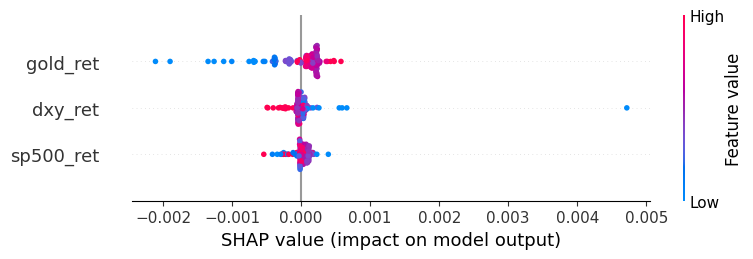

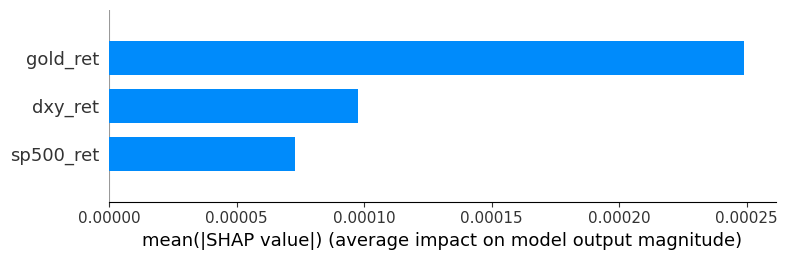

In [ ]:
# 1️⃣ Install SHAP (if not already installed)
!pip install shap --quiet

# 2️⃣ Import SHAP
import shap

# 3️⃣ Create a Tree Explainer for the Random Forest
explainer = shap.TreeExplainer(best_rf)

# 4️⃣ Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 5️⃣ Summary plot (dot) — shows impact of features on predictions
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

# 6️⃣ Optional: Summary plot (bar) — ranks features by overall importance
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type="bar")


In [ ]:
# ---------------------------
# Member 4 add-on: SHAP plots, dependence plots, and plain-English summary
# (Append this cell AFTER your modeling / best_rf cell)
# ---------------------------

# (1) Imports - should already be installed earlier, but import now
import shap
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
import pandas as pd
import os

OUTPUT_DIR = "xai_outputs_member4"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------
# (2) Create SHAP explainer & values
# ---------------------------
# If best_rf and X_test are present from previous cells, use them.
# If not, this cell will raise a NameError so ensure previous cell was executed.
explainer = shap.TreeExplainer(best_rf)            # RandomForest -> TreeExplainer
# For regression shap_values will be an (n_samples, n_features) array
shap_values = explainer.shap_values(X_test)

# ---------------------------
# (3) SHAP summary plot (dot / beeswarm)
# ---------------------------
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title("SHAP Summary (Beeswarm) — feature impact on GBPUSD returns")
plt.tight_layout()
beeswarm_path = os.path.join(OUTPUT_DIR, "shap_summary_beeswarm.png")
plt.savefig(beeswarm_path, bbox_inches='tight', dpi=300)
plt.close()
print("Saved:", beeswarm_path)
files.download(beeswarm_path)

# ---------------------------
# (4) SHAP bar plot (mean |SHAP| = global importance)
# ---------------------------
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (mean |SHAP|)")
plt.tight_layout()
bar_path = os.path.join(OUTPUT_DIR, "shap_feature_importance_bar.png")
plt.savefig(bar_path, bbox_inches='tight', dpi=300)
plt.close()
print("Saved:", bar_path)
files.download(bar_path)

# ---------------------------
# (5) Identify top features by mean absolute SHAP and make dependence plots
# ---------------------------
# mean absolute shap across test set for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
feat_shap_series = pd.Series(mean_abs_shap, index=feature_cols).sort_values(ascending=False)
top_features = feat_shap_series.index.tolist()
print("Top features by mean |SHAP| (top 5):")
print(feat_shap_series.head(5))

# create dependence plots for top 3 (or fewer if less features)
n_depend = min(3, len(top_features))
depend_paths = []
for i in range(n_depend):
    f = top_features[i]
    plt.figure(figsize=(8,5))
    # shap.dependence_plot requires the feature name or index and the shap_values for the dataset
    try:
        shap.dependence_plot(f, shap_values, X_test, feature_names=feature_cols, show=False)
    except Exception:
        # fallback in case of older shap API expecting arrays
        shap.dependence_plot(f, shap_values, X_test, show=False)
    plt.title(f"SHAP Dependence Plot — {f}")
    dep_path = os.path.join(OUTPUT_DIR, f"shap_dependence_{i+1}_{f}.png")
    plt.tight_layout()
    plt.savefig(dep_path, bbox_inches='tight', dpi=300)
    plt.close()
    depend_paths.append(dep_path)
    print("Saved:", dep_path)
    files.download(dep_path)

# ---------------------------
# (6) Generate a simple finance-language explanation for top variables
# ---------------------------
# For direction, compute the mean *signed* SHAP value per feature across test set:
mean_signed_shap = np.mean(shap_values, axis=0)
signed_shap_series = pd.Series(mean_signed_shap, index=feature_cols).loc[top_features]

# Build summary text
summary_lines = []
summary_lines.append("XAI Summary — Top features influencing GBPUSD daily returns (based on SHAP)\n")
summary_lines.append("Top features (ranked by mean absolute SHAP value):")
for idx, feat in enumerate(top_features[:5], start=1):
    ma = feat_shap_series[feat]
    signed = signed_shap_series[feat] if feat in signed_shap_series.index else np.nan
    direction = "positive" if signed > 0 else "negative" if signed < 0 else "mixed/neutral"
    # Qualitative impact magnitude
    if ma > np.percentile(mean_abs_shap, 90):
        mag = "strong"
    elif ma > np.percentile(mean_abs_shap, 60):
        mag = "moderate"
    else:
        mag = "small"
    summary_lines.append(f"{idx}. {feat} — mean |SHAP|={ma:.5f} — overall {direction} influence ({mag} effect).")

summary_lines.append("\nInterpretation guidance (finance language):")
# Provide finance-oriented example interpretations for each top feature
for feat in top_features[:5]:
    signed = signed_shap_series[feat] if feat in signed_shap_series.index else 0.0
    direction = "increases" if signed > 0 else "decreases" if signed < 0 else "has mixed influence"
    # Example sentences - keep generic because we don't know feature semantics exactly (gold_ret etc.)
    if feat.lower().find("gold") >= 0:
        example = f"When {feat} (gold returns) rises, the model predicts GBPUSD return {direction} — this may reflect risk-on/risk-off or safe-haven flows affecting sterling-dollar."
    elif feat.lower().find("sp500") >= 0 or feat.lower().find("stock") >= 0:
        example = f"When {feat} (equity returns) rises, the model predicts GBPUSD return {direction} — equity gains often signal global risk appetite which can push the dollar/sterling relationship."
    elif feat.lower().find("dxy") >= 0 or feat.lower().find("dollar") >= 0:
        example = f"When {feat} (DXY) rises, the model predicts GBPUSD return {direction} — a stronger dollar (higher DXY) typically exerts downward pressure on GBPUSD (sterling weakens against USD)."
    else:
        example = f"{feat}: higher values {direction} predicted GBPUSD returns according to the model."

    summary_lines.append("- " + example)

summary_text = "\n".join(summary_lines)

# Save summary to file and print
summary_file = os.path.join(OUTPUT_DIR, "xai_plain_english_summary.txt")
with open(summary_file, "w") as f:
    f.write(summary_text)

print("\n--- XAI Plain-English Summary ---\n")
print(summary_text)
print("\nSaved summary to:", summary_file)
files.download(summary_file)

# ---------------------------
# (7) Short note for report insertion (copy-paste friendly)
# ---------------------------
report_insert = f"""
Section 4 — Explainable AI results (copy-paste)

Model: Tuned RandomForest (best_rf)
Target: GBPUSD daily return (pct change)
Top features (SHAP ranked): {', '.join(top_features[:5])}

Key takeaways:
- The SHAP summary (beeswarm) shows which features most consistently alter model predictions and whether high or low values push predictions up or down.
- The SHAP bar chart ranks features by average influence (mean |SHAP|).
- Dependence plots (attached) show the functional relationship: how changes in one feature are associated with marginal changes in predicted GBPUSD return, including possible non-linearities.

Interpretation (finance language):
{summary_text.splitlines()[-6:]}
"""

report_file = os.path.join(OUTPUT_DIR, "report_snippet_for_section4.txt")
with open(report_file, "w") as f:
    f.write(report_insert)

print("\nSaved report snippet:", report_file)
files.download(report_file)

# End of add-on cell


Saved: xai_outputs_member4/shap_summary_beeswarm.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: xai_outputs_member4/shap_feature_importance_bar.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Top features by mean |SHAP| (top 5):
gold_ret     0.000249
dxy_ret      0.000098
sp500_ret    0.000073
dtype: float64
Saved: xai_outputs_member4/shap_dependence_1_gold_ret.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: xai_outputs_member4/shap_dependence_2_dxy_ret.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: xai_outputs_member4/shap_dependence_3_sp500_ret.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- XAI Plain-English Summary ---

XAI Summary — Top features influencing GBPUSD daily returns (based on SHAP)

Top features (ranked by mean absolute SHAP value):
1. gold_ret — mean |SHAP|=0.00025 — overall positive influence (strong effect).
2. dxy_ret — mean |SHAP|=0.00010 — overall positive influence (small effect).
3. sp500_ret — mean |SHAP|=0.00007 — overall positive influence (small effect).

Interpretation guidance (finance language):
- When gold_ret (gold returns) rises, the model predicts GBPUSD return increases — this may reflect risk-on/risk-off or safe-haven flows affecting sterling-dollar.
- When dxy_ret (DXY) rises, the model predicts GBPUSD return increases — a stronger dollar (higher DXY) typically exerts downward pressure on GBPUSD (sterling weakens against USD).
- When sp500_ret (equity returns) rises, the model predicts GBPUSD return increases — equity gains often signal global risk appetite which can push the dollar/sterling relationship.

Saved summary to: xai_out

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Saved report snippet: xai_outputs_member4/report_snippet_for_section4.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Collect predictions
models = {
    "Decision Tree": (dt_pred_train, dt_pred_test),
    "Random Forest": (rf_pred_train, rf_pred_test),
    "Tuned Random Forest": (best_rf.predict(X_train), best_rf.predict(X_test))
}

# Prepare table
rows = []
for name, (pred_train, pred_test) in models.items():
    row = {
        "Model": name,
        "Train R²": r2_score(y_train, pred_train),
        "Test R²": r2_score(y_test, pred_test),
        "Train MAE": mean_absolute_error(y_train, pred_train),
        "Test MAE": mean_absolute_error(y_test, pred_test),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, pred_test))
    }
    rows.append(row)

performance_df = pd.DataFrame(rows)
performance_df


NameError: name 'dt_pred_train' is not defined

In [ ]:
# If models are already trained:
dt_pred_train = dt_model.predict(X_train)
dt_pred_test = dt_model.predict(X_test)

rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

tuned_rf_pred_train = best_rf.predict(X_train)
tuned_rf_pred_test = best_rf.predict(X_test)


In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Tuned Random Forest (use your best parameters)
best_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)


In [ ]:
dt_pred_train = dt_model.predict(X_train)
dt_pred_test = dt_model.predict(X_test)

rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

tuned_rf_pred_train = best_rf.predict(X_train)
tuned_rf_pred_test = best_rf.predict(X_test)


In [ ]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

models = {
    "Decision Tree": (dt_pred_train, dt_pred_test),
    "Random Forest": (rf_pred_train, rf_pred_test),
    "Tuned Random Forest": (tuned_rf_pred_train, tuned_rf_pred_test)
}

rows = []
for name, (pred_train, pred_test) in models.items():
    row = {
        "Model": name,
        "Train R²": r2_score(y_train, pred_train),
        "Test R²": r2_score(y_test, pred_test),
        "Train MAE": mean_absolute_error(y_train, pred_train),
        "Test MAE": mean_absolute_error(y_test, pred_test),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, pred_train)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, pred_test))
    }
    rows.append(row)

performance_df = pd.DataFrame(rows)
performance_df


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import pandas as pd

# Load the uploaded file
df_groupmate = pd.read_excel(list(uploaded.keys())[0])

# Preview
df_groupmate.head()


In [ ]:
# Example: check the first 10 rows of GBPUSD and return
df_groupmate[['GBPUSD', 'Return']].head(10)


In [ ]:
df_groupmate.columns


In [ ]:
df_groupmate[['GBPUSD', 'GBPUSD Return']].head(10)


In [ ]:
# Check exact column names
print(df_groupmate.columns.tolist())


In [ ]:
# Show all column names
print(df_groupmate.columns.tolist())

# Preview first 5 rows to spot which column might be the daily return
df_groupmate.head()


In [ ]:
# Rename the column to 'GBPUSD_Return' for easier use
df_groupmate.rename(columns={'Unnamed: 6': 'GBPUSD_Return'}, inplace=True)

# Check first 5 rows
df_groupmate[['GBPUSD', 'GBPUSD_Return']].head()


In [ ]:
# Skip the first two rows with metadata
df_clean = df_groupmate.iloc[2:].copy()

# Reset the index
df_clean.reset_index(drop=True, inplace=True)

# Convert numeric columns to float
df_clean['GBPUSD'] = df_clean['GBPUSD'].astype(float)
df_clean['GBPUSD_Return'] = df_clean['GBPUSD_Return'].astype(float)

# Check cleaned dataframe
df_clean[['GBPUSD', 'GBPUSD_Return']].head()


In [ ]:
# Step 1: Remove the first row with NaN in returns
df_clean = df_groupmate.iloc[1:].copy()

# Step 2: Reset index
df_clean.reset_index(drop=True, inplace=True)

# Step 3: Convert numeric columns to float
df_clean['GBPUSD'] = df_clean['GBPUSD'].astype(float)
df_clean['GBPUSD_Return'] = df_clean['GBPUSD_Return'].astype(float)

# Step 4: Check the first few rows
df_clean[['GBPUSD', 'GBPUSD_Return']].head()


In [ ]:
# Step 1: Keep only numeric rows in GBPUSD_Return
df_clean = df_groupmate.copy()

# Use pd.to_numeric with errors='coerce' to turn non-numeric into NaN
df_clean['GBPUSD_Return'] = pd.to_numeric(df_clean['GBPUSD_Return'], errors='coerce')

# Step 2: Drop rows where GBPUSD_Return is NaN
df_clean = df_clean.dropna(subset=['GBPUSD_Return']).reset_index(drop=True)

# Step 3: Convert GBPUSD column to float (safe version)
df_clean['GBPUSD'] = pd.to_numeric(df_clean['GBPUSD'], errors='coerce')

# Step 4: Check the cleaned data
df_clean[['GBPUSD', 'GBPUSD_Return']].head(10)


In [ ]:
df_clean['GBPUSD_Return'].describe()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_clean['GBPUSD_Return'])
plt.title('GBPUSD Daily Returns')
plt.xlabel('Day')
plt.ylabel('Return')
plt.show()


In [ ]:
df_clean['GBPUSD_CumReturn'] = (1 + df_clean['GBPUSD_Return']).cumprod() - 1


In [ ]:
# Make sure there are no hidden spaces
df_clean.columns = df_clean.columns.str.strip()

# Drop or fill NaN values before cumulative calculation
df_clean['GBPUSD_Return'] = df_clean['GBPUSD_Return'].fillna(0)

# Now calculate cumulative returns
df_clean['GBPUSD_CumReturn'] = (1 + df_clean['GBPUSD_Return']).cumprod() - 1


In [ ]:
# Show the first 10 cumulative returns
df_clean[['GBPUSD_CumReturn']].head(10)


In [ ]:
from sklearn.model_selection import train_test_split

X = df[features]   # your engineered features
y = df['GBPAUD_Return']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import pandas as pd

df = pd.read_csv('your_dataset.csv')  # replace with your actual CSV file
df.head()
